In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency


pd. set_option("display.max_columns", None)
pd. set_option("display.max_rows", None)
import warnings
warnings.filterwarnings('ignore')

In [49]:
# Load data
df_raw = pd.read_csv('credit_card_2015_2016.csv')

In [50]:
df_raw.head()

,term,sub_grade,grade,emp_length,issue_y,revol_util_n,int_rate_n,installment_n,tot_hi_cred_lim_n,dti_n,avg_cur_bal_n,all_util_n,acc_open_past_24mths_n,annual_inc_n,loan_amnt_n,loan_status
0,60 months,C4,C,10+ years,15,87.1,14.31,702.30,350349,36.91,35256,100,1,98000.0,29975,Fully Paid
1,60 months,C1,C,< 1 year,15,57.0,12.29,268.70,43525,18.80,2990,100,2,45000.0,12000,Fully Paid
2,36 months,B3,B,1 year,15,42.8,9.99,258.10,72655,19.34,6569,100,5,62500.0,8000,Fully Paid
3,36 months,A4,A,3 years,15,95.7,7.26,433.95,62695,11.31,9416,100,0,127000.0,14000,Fully Paid
4,36 months,B5,B,< 1 year,15,91.8,11.53,758.78,120674,23.07,7059,100,6,116000.0,23000,Fully Paid


In [51]:
df_raw.info() #emp_length has missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   term                    40000 non-null  object 
 1   sub_grade               40000 non-null  object 
 2   grade                   40000 non-null  object 
 3   emp_length              37459 non-null  object 
 4   issue_y                 40000 non-null  int64  
 5   revol_util_n            40000 non-null  float64
 6   int_rate_n              40000 non-null  float64
 7   installment_n           40000 non-null  float64
 8   tot_hi_cred_lim_n       40000 non-null  int64  
 9   dti_n                   40000 non-null  float64
 10  avg_cur_bal_n           40000 non-null  int64  
 11  all_util_n              40000 non-null  int64  
 12  acc_open_past_24mths_n  40000 non-null  int64  
 13  annual_inc_n            40000 non-null  float64
 14  loan_amnt_n             40000 non-null

In [52]:
# Separate training and OOT data
df_train = df_raw[df_raw['issue_y'] == 15].copy()
df_oot = df_raw[df_raw['issue_y'] == 16].copy()

print(df_train.shape, df_oot.shape)

(20000, 16) (20000, 16)


In [53]:
df_train.info() # emp_length has missing values

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   term                    20000 non-null  object 
 1   sub_grade               20000 non-null  object 
 2   grade                   20000 non-null  object 
 3   emp_length              18747 non-null  object 
 4   issue_y                 20000 non-null  int64  
 5   revol_util_n            20000 non-null  float64
 6   int_rate_n              20000 non-null  float64
 7   installment_n           20000 non-null  float64
 8   tot_hi_cred_lim_n       20000 non-null  int64  
 9   dti_n                   20000 non-null  float64
 10  avg_cur_bal_n           20000 non-null  int64  
 11  all_util_n              20000 non-null  int64  
 12  acc_open_past_24mths_n  20000 non-null  int64  
 13  annual_inc_n            20000 non-null  float64
 14  loan_amnt_n             20000 non-null  int

In [ ]:
# Create Outcome variable (simply put, 1 means bad  or risky loan, 0 means good loan)
df_train['Outcome'] = df_train['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Late (31-120 days)'] else 0)
print(df_train['Outcome'].value_counts())
print(df_train['Outcome'].value_counts(normalize=True))

In [54]:
# Basic information of categorical data
print("Counts of categorical features:\n", df_train.describe(include=['object', 'category']))
print('************Loan Status Counts******************')
print(df_train.value_counts(['loan_status']))
print(df_train['loan_status'].value_counts(normalize=True))
print('************Term Counts******************')
print(df_train.value_counts(['term']))
print(df_train['term'].value_counts(normalize=True))
print('*********Grade Counts*************')
print(df_train.value_counts(['grade']))
print(df_train['grade'].value_counts(normalize=True))
print('*********Sub Grade Counts*************')
print(df_train.value_counts(['sub_grade']))
print(df_train['sub_grade'].value_counts(normalize=True))

Counts of categorical features:
              term sub_grade  grade emp_length loan_status
count       20000     20000  20000      18747       20000
unique          2        34      7         11           3
top     36 months        A5      B  10+ years  Fully Paid
freq        15696      1606   6805       6099       16401
************Loan Status Counts******************
loan_status       
Fully Paid            16401
Charged Off            3413
Late (31-120 days)      186
Name: count, dtype: int64
loan_status
Fully Paid            0.82005
Charged Off           0.17065
Late (31-120 days)    0.00930
Name: proportion, dtype: float64
************Term Counts******************
term     
36 months    15696
60 months     4304
Name: count, dtype: int64
term
36 months    0.7848
60 months    0.2152
Name: proportion, dtype: float64
*********Grade Counts*************
grade
B        6805
A        5902
C        4760
D        1645
E         734
F         137
G          17
Name: count, dtype: int64
grade

In [55]:
# Map emp_length to ordinal numbers as per the feature definition ( Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years)
emp_length_map = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
                  '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}

df_train['emp_length'] = df_train['emp_length'].map(emp_length_map)

# Check missing values
print(df_train['emp_length'].isnull().sum())

1253


In [56]:
print("\nBasic Statistics of Numerical features:\n", df_train.describe().round(2))


Basic Statistics of Numerical features:
        emp_length  issue_y  revol_util_n  int_rate_n  installment_n  \
count    18747.00  20000.0      20000.00    20000.00       20000.00   
mean         5.73     15.0         56.52       10.79         451.95   
std          3.75      0.0         22.25        3.75         246.46   
min          0.00     15.0         -1.00        5.32          30.12   
25%          2.00     15.0         39.90        7.89         267.21   
50%          6.00     15.0         56.50        9.99         392.81   
75%         10.00     15.0         73.53       12.99         602.30   
max         10.00     15.0        124.70       27.88        1306.90   

       tot_hi_cred_lim_n     dti_n  avg_cur_bal_n  all_util_n  \
count           20000.00  20000.00       20000.00    20000.00   
mean           173900.06     18.93       12949.71       98.50   
std            177436.45      8.47       15657.95        8.37   
min              2700.00      0.00           7.00        4

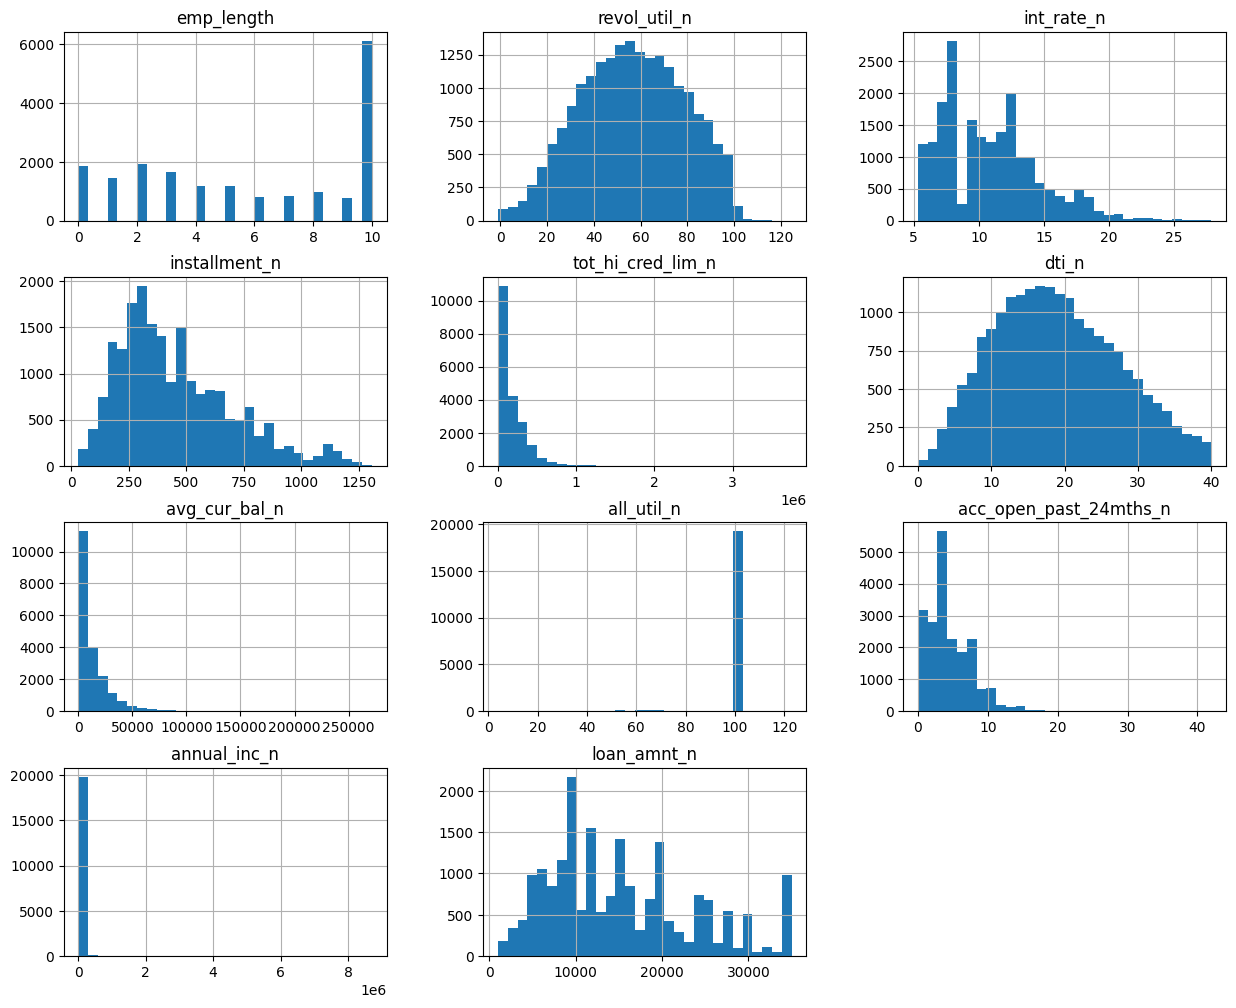

In [57]:
# Distribution plots for numerical features (excluding issue year)
num_cols = [col for col in df_train.select_dtypes(include='number').columns if col != 'issue_y']
df_train[num_cols].hist(figsize=(15, 12), bins=30)
plt.show()

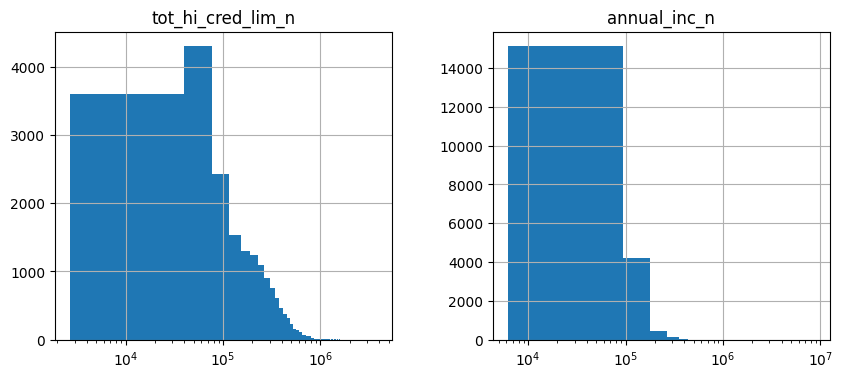

In [58]:
# Analyze these 2 by increasing the # of bins as the distribution with 30 bins is not clear
axes = df_train[['tot_hi_cred_lim_n', 'annual_inc_n']].hist(bins=100, figsize=(10, 4))
for ax in axes.flatten():
    ax.set_xscale('log')
# plt.tight_layout()
plt.show()

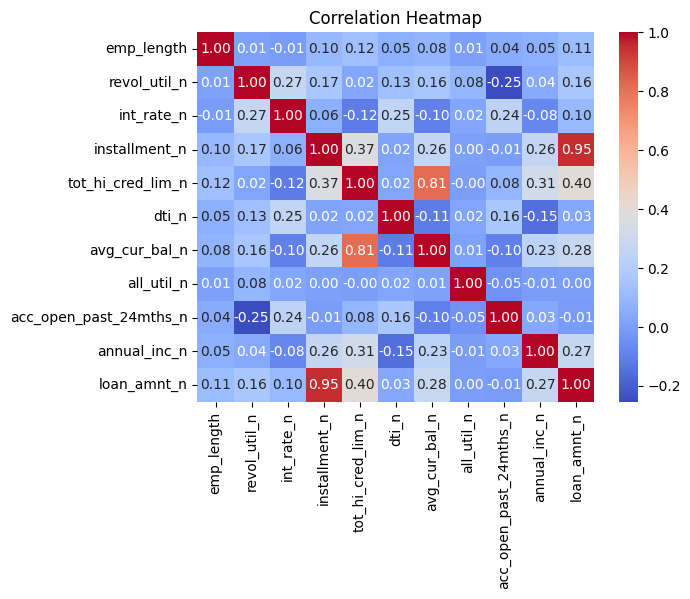

In [59]:
# Correlation map
# plt.figure(figsize=(12, 10))
sns.heatmap(df_train[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

XGBoost handles multicollinearity automatically during training, so dropping highly correlated features is not strictly necessary but (loan amount and installment) are highly correlated and hence redundant.

In [ ]:
# drop installment_n and update the list of numerical columns
df_train.drop(['installment_n'], axis=1, inplace=True)
num_cols.remove('installment_n')

Boxplot and outlier check: xgboost is generally robust to outliers, but it may impact the generalizability of the model

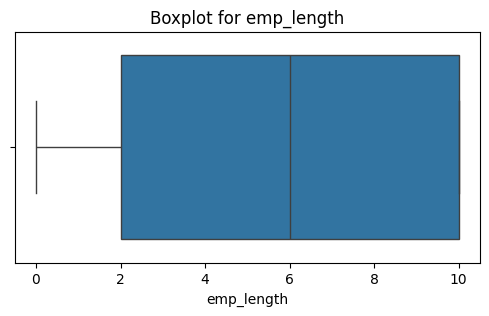

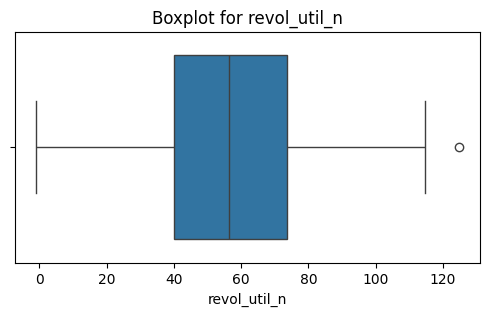

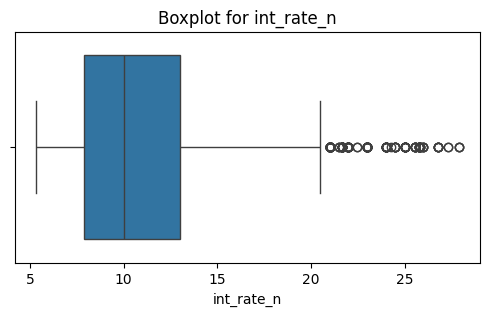

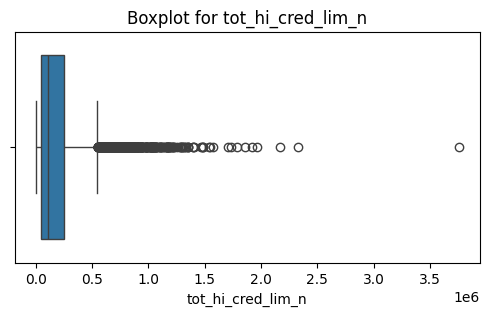

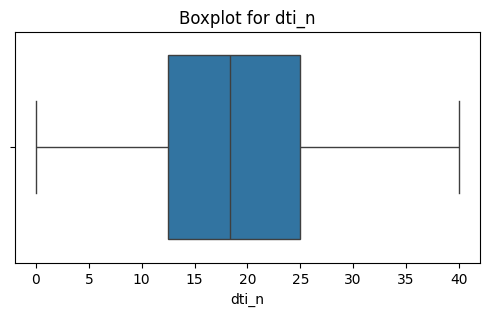

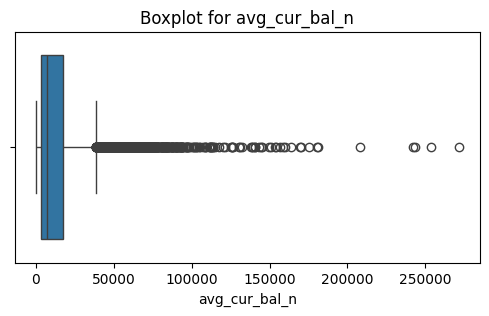

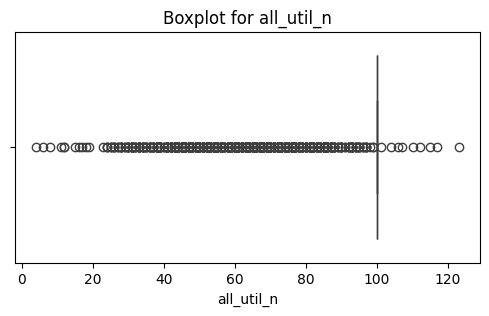

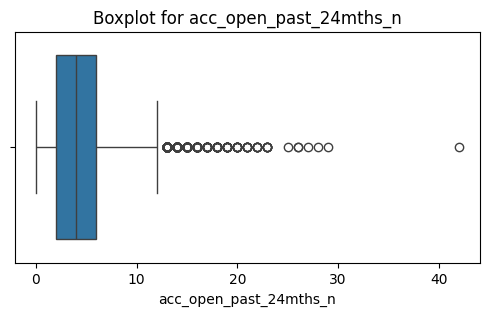

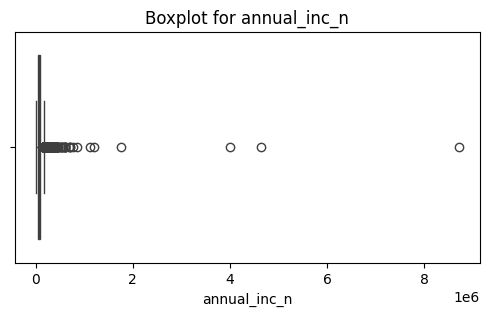

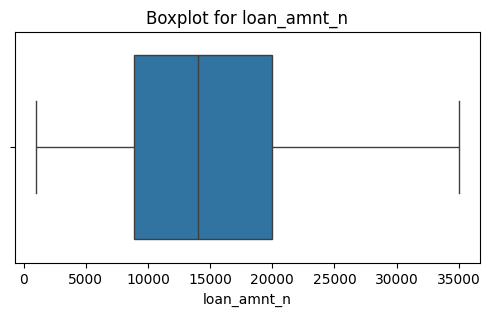

emp_length                   0
revol_util_n                 1
int_rate_n                 251
tot_hi_cred_lim_n          763
dti_n                        0
avg_cur_bal_n             1262
all_util_n                 773
acc_open_past_24mths_n     397
annual_inc_n               947
loan_amnt_n                  0
dtype: int64


In [75]:
# Check for outliers
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_train[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

# Outlier detection using IQR
Q1 = df_train[num_cols].quantile(0.25)
Q3 = df_train[num_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df_train[num_cols] < (Q1 - 1.5 * IQR)) | (df_train[num_cols] > (Q3 + 1.5 * IQR))).sum()
print(outliers)

Run t-test to check if there is statistically significant difference between the means of a numerical variables for good and bad loans

Unlike the t-test, which compares means and assumes that the data are normally distributed and have equal variances, the Mann-Whitney U test does not require the data to be normally distributed and is suitable for data when the assumptions of the t-test are not met

In [78]:
results = []

for col in num_cols:
    group0 = df_train[df_train['Outcome'] == 0][col].dropna()
    group1 = df_train[df_train['Outcome'] == 1][col].dropna()
    
    # t-test
    t_stat, t_p = ttest_ind(group0, group1, equal_var=False)
    # Mann-Whitney U test
    u_stat, u_p = mannwhitneyu(group0, group1, alternative='two-sided')
    
    # Significance check (alpha = 0.05)
    t_significant = 'Significant' if t_p < 0.05 else 'Not Significant'
    u_significant = 'Significant' if u_p < 0.05 else 'Not Significant'
    
    results.append({
        'feature': col,
        't-test p-value': t_p,
        't-test significance': t_significant,
        'Mann-Whitney p-value': u_p,
        'Mann-Whitney significance': u_significant
    })

summary_df = pd.DataFrame(results)
print(summary_df)


                  feature  t-test p-value t-test significance  \
0              emp_length    6.812118e-01     Not Significant   
1            revol_util_n    1.036634e-27         Significant   
2              int_rate_n    0.000000e+00         Significant   
3       tot_hi_cred_lim_n    8.128528e-33         Significant   
4                   dti_n    9.970022e-66         Significant   
5           avg_cur_bal_n    1.184267e-35         Significant   
6              all_util_n    1.402460e-01     Not Significant   
7  acc_open_past_24mths_n    1.963690e-56         Significant   
8            annual_inc_n    5.576249e-03         Significant   
9             loan_amnt_n    2.141723e-10         Significant   

   Mann-Whitney p-value Mann-Whitney significance  
0          6.859972e-01           Not Significant  
1          3.581338e-27               Significant  
2          0.000000e+00               Significant  
3          1.845988e-25               Significant  
4          2.424016e-65 

In [60]:
# impute employee length using KNN

# imputer = KNNImputer(n_neighbors=5)
# df_train[['emp_length_n_new']] = imputer.fit_transform(df_train[['emp_length_n']])

# diff_mask = df_train['emp_length_n'] != df_train['emp_length_n_new']
# differences = df_train.loc[diff_mask, ['emp_length_n', 'emp_length_n_new']]
# print(differences)

# KNN imputer imputed missing values with mean 5.72 which is not appropriate for an ordinal variable
# On diff note, 10 is much more frequent than other values, imputing with 10 will further increase its dominance 

df_train['emp_length'].fillna(df_train['emp_length'].median(), inplace=True)

In [61]:
print("\nMissing Values:\n", df_train['emp_length'].isnull().sum())


Missing Values:
 0


Outcome
0    16401
1     3599
Name: count, dtype: int64
Outcome
0    0.82005
1    0.17995
Name: proportion, dtype: float64


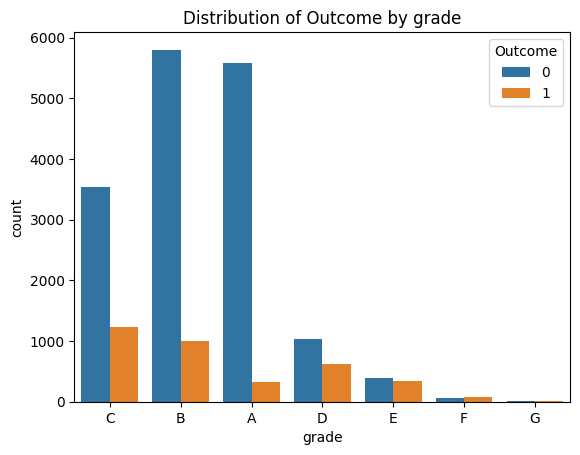

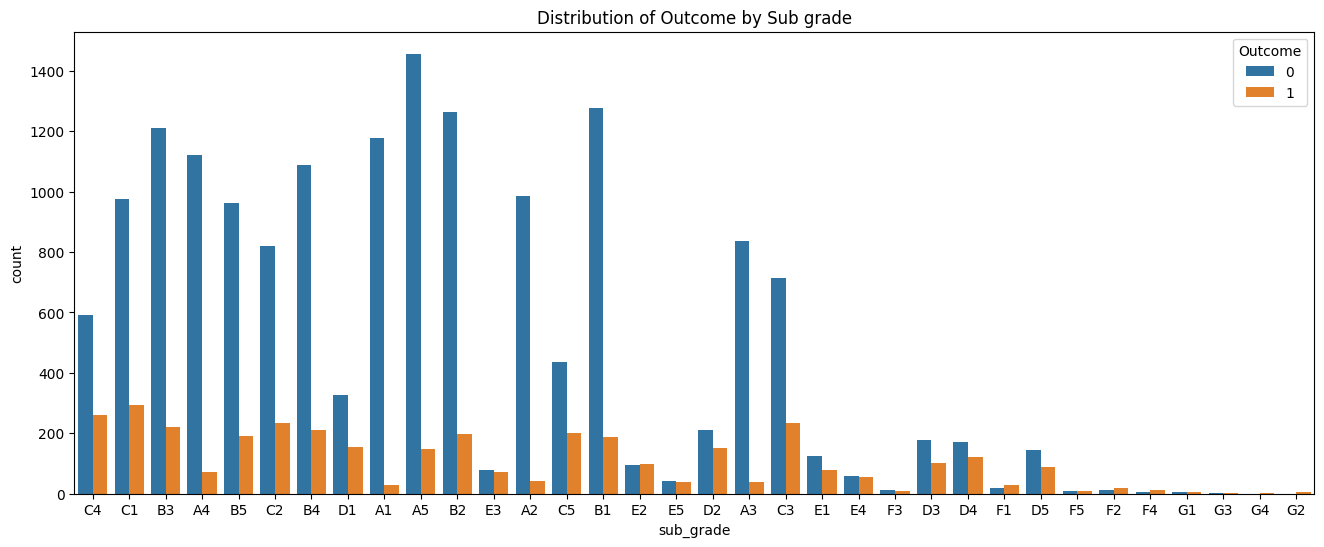

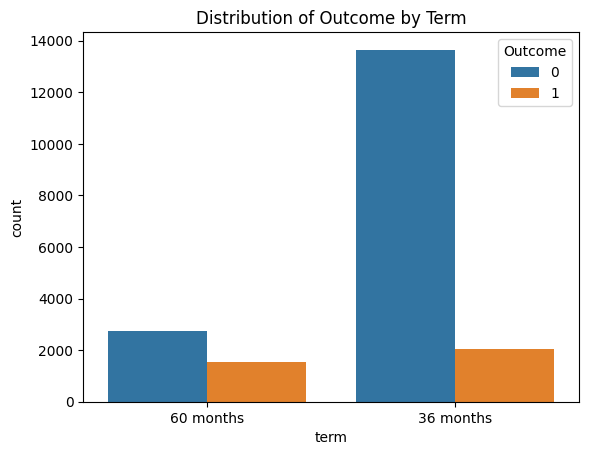

In [80]:
#Plot categorical variables with Outcome variable
sns.countplot(data=df_train, x='grade', hue='Outcome')
plt.title('Distribution of Outcome by grade')
plt.show()

plt.figure(figsize=(16, 6))
sns.countplot(data=df_train, x='sub_grade', hue='Outcome')
plt.title('Distribution of Outcome by Sub grade')
plt.show()

sns.countplot(data=df_train, x='term', hue='Outcome')
plt.title('Distribution of Outcome by Term')
plt.show()

Run the chi-square test to determine whether there is a significant relationship between two categorical variables and Outcome

In [84]:
cat_cols = ['term', 'grade', 'sub_grade']
target = 'Outcome'

def chi_square_test(data, predictor, target):
    contingency_table = pd.crosstab(data[predictor], data[target])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Store results
results = []

for col in cat_cols:
    chi2, p = chi_square_test(df_train, col, target)
    significance = 'Significant' if p < 0.05 else 'Not Significant'
    results.append({'feature': col, 'chi2_stat': chi2, 'p_value': p, 'significance': significance})

# Display as DataFrame
results_df = pd.DataFrame(results)
print(results_df)


     feature    chi2_stat        p_value significance
0       term  1208.077035  1.071369e-264  Significant
1      grade  1838.200860   0.000000e+00  Significant
2  sub_grade  1961.877626   0.000000e+00  Significant


Since sub_grade is at more granular level of grade, there is a possibility they are closely associated. We can check with Cramer's V which measures the strength of association between two categorical variables 

In [97]:
contingency = pd.crosstab(df_train['grade'], df_train['sub_grade'])
chi2, p, dof, expected = chi2_contingency(contingency)
# Calculate Cramer’s V
n = contingency.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape)-1)))
print(cramers_v)

1.0


In [ ]:
# Encode categorical variables
le_grade = LabelEncoder()
df_train['grade'] = le_grade.fit_transform(df_train['grade'])

le_subgrade = LabelEncoder()
df_train['sub_grade'] = le_subgrade.fit_transform(df_train['sub_grade'])